# 140年分の東京の気温を分析

[気象庁](http://www.data.jma.go.jp/gmd/risk/obsdl/index.php)のデータを分析する．頂いたコメントをもとに，一部の処理を修正する．

- インラインで表示しないようにする．
- pandas.read_csv(encoding='Shift-JIS')を使う．

## 環境構築

In [2]:
# 解像度を高める
%config InlineBackend.figure_format = 'retina' 

# （本当はよくないけど）警告メッセージを無視する
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np # 数値計算
import pandas as pd # DataFrame
import matplotlib.pyplot as plt # グラフ描画
import seaborn as sns # グラフ描画設定
import json # jsonファイルの読み書き
import itertools # 組み込み関数．特にproductをよく使う
from datetime import datetime, timedelta # 日付
from tqdm import tqdm # forループの進捗状況確認

sns.set_style(style='ticks') # グラフスタイルの指定

In [5]:
from fbprophet import Prophet

## グローバル変数

In [6]:
read_path = 'data/raw/'

## ファイル読み込み

In [11]:
years = range(1870, 2020, 10)

all_data = pd.DataFrame()

for year in tqdm(years):
    data_file = 'data_{}.csv'.format(year)
    
    # 普通にpd.read_csvすると読み込めない．Encodingで指定する．
    data = pd.read_csv(
        read_path+data_file, encoding='Shift-JIS', skiprows=5, index_col=0, 
        usecols=[0, 1, 4, 7])
        
    # カラムの処理
    data.index = pd.to_datetime(data.index)
    data.columns = ['average', 'high', 'low']
    
    all_data = pd.concat([all_data, data])

100%|██████████| 15/15 [00:00<00:00, 103.22it/s]


In [12]:
all_data.shape

(53528, 3)

In [13]:
all_data.average.isna().sum() / all_data.shape[0], all_data.average.isna().sum()

(0.023763264086085787, 1272)

先頭の2%ちょいはデータなし．

In [14]:
# Nanのデータは削除
all_data = all_data.dropna(how='all')

In [15]:
all_data.shape

(52266, 3)

In [16]:
all_data.head()

,average,high,low
1875-06-10,20.5,24.5,16.4
1875-06-11,19.7,25.7,13.7
1875-06-12,20.7,25.1,16.3
1875-06-13,21.7,23.2,20.1
1875-06-15,19.3,21.8,16.8


In [17]:
all_data.tail()

,average,high,low
2018-07-17,29.9,34.8,26.9
2018-07-18,30.5,35.3,26.7
2018-07-19,29.9,34.8,26.6
2018-07-20,29.9,34.2,27.0
2018-07-21,30.5,34.9,26.9


## 平均気温

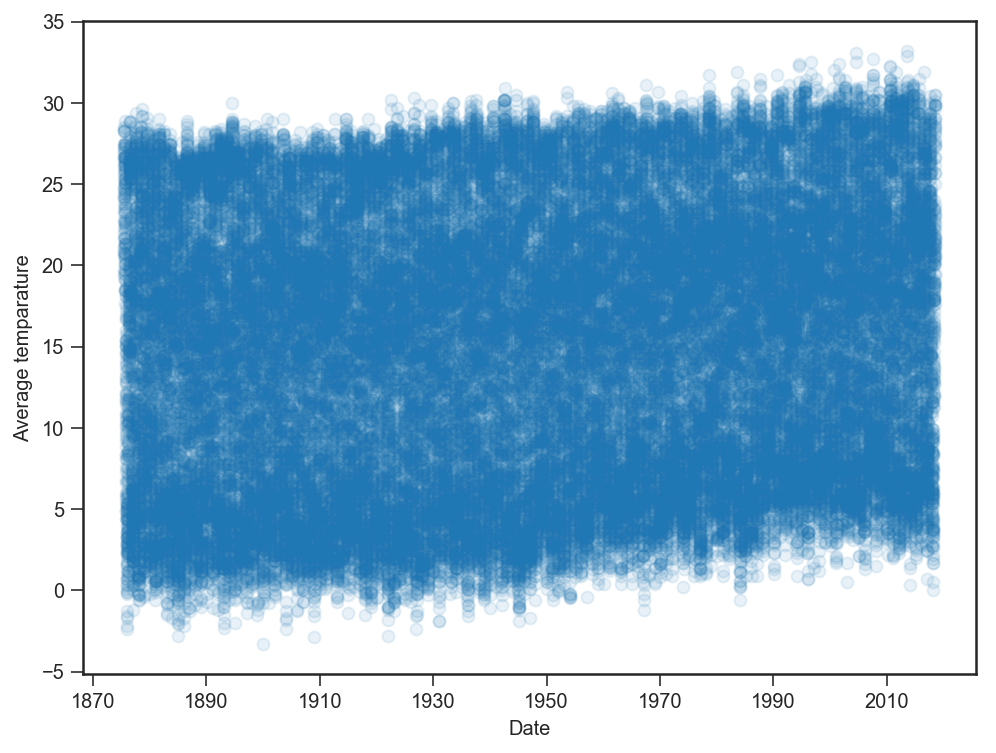

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(all_data.index, all_data.average, 'o', alpha=.1)
plt.xlabel('Date')
plt.ylabel('Average temparature')
plt.show()

In [19]:
ave_data = pd.DataFrame()
ave_data['ds'] = all_data.index
ave_data['y'] = all_data.average.values

In [20]:
m = Prophet(weekly_seasonality=False)
m.fit(ave_data)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# 将来30日間を予測
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

Text(65.125,0.5,'Average')

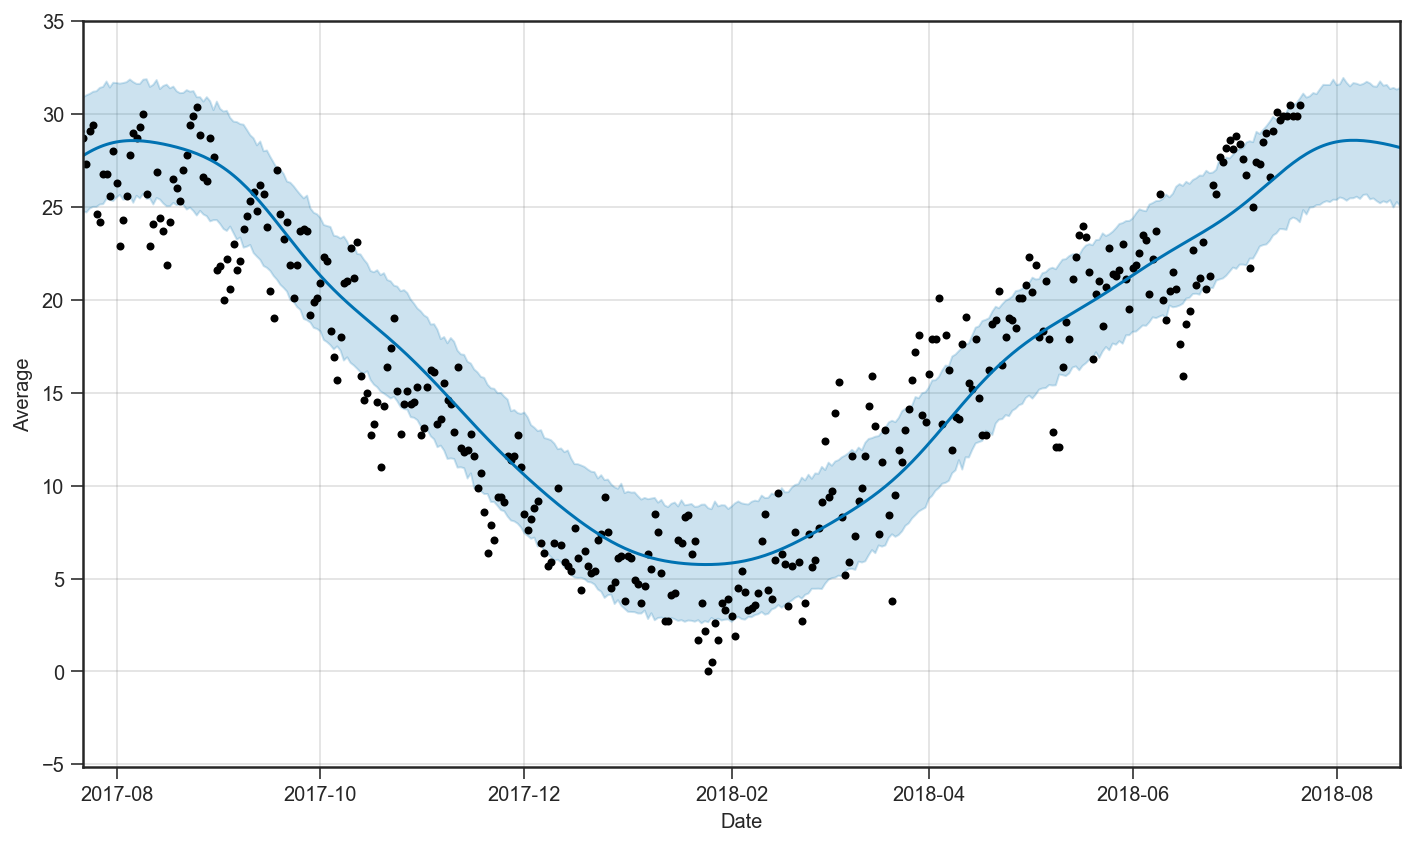

In [22]:
_ = m.plot(forecast)
plt.xlim(future.ds.iloc[-365-30], future.ds.iloc[-1])
plt.xlabel('Date')
plt.ylabel('Average')

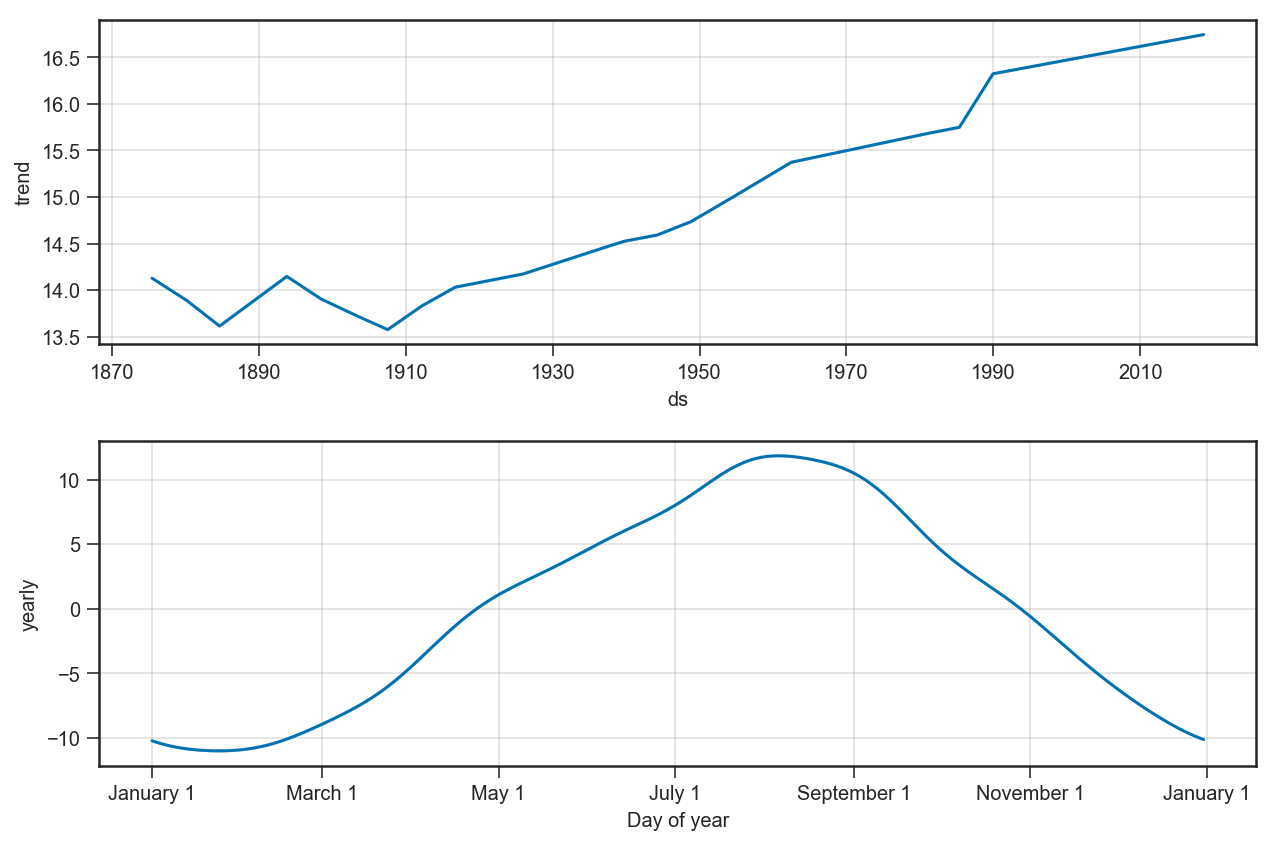

In [23]:
_ = m.plot_components(forecast)

In [24]:
forecast.iloc[-40:, [0, -1]]

,ds,yhat
52256,2018-07-12,26.344606
52257,2018-07-13,26.499637
52258,2018-07-14,26.653391
52259,2018-07-15,26.805163
52260,2018-07-16,26.954241
52261,2018-07-17,27.099913
52262,2018-07-18,27.241478
52263,2018-07-19,27.378260
52264,2018-07-20,27.509616
52265,2018-07-21,27.634945


## 最高気温

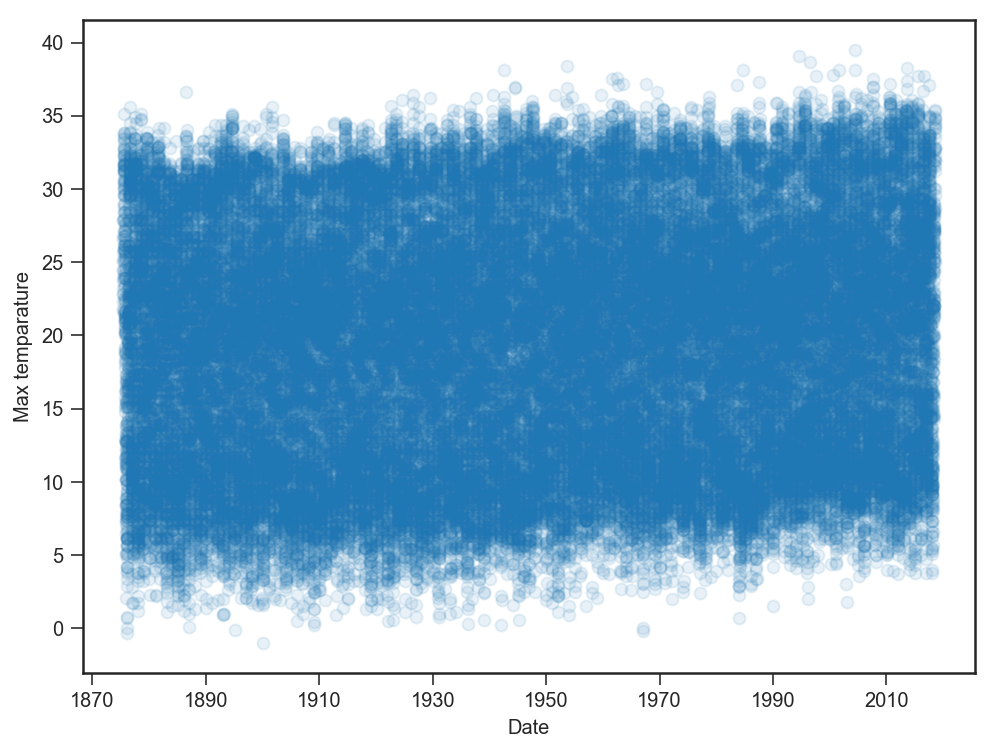

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(all_data.index, all_data.high, 'o', alpha=.1)
plt.xlabel('Date')
plt.ylabel('Max temparature')
plt.show()

In [26]:
high_data = pd.DataFrame()
high_data['ds'] = all_data.index
high_data['y'] = all_data.high.values

In [27]:
m = Prophet(weekly_seasonality=False)
m.fit(high_data)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
# 将来30日間を予測
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

Text(65.375,0.5,'Max')

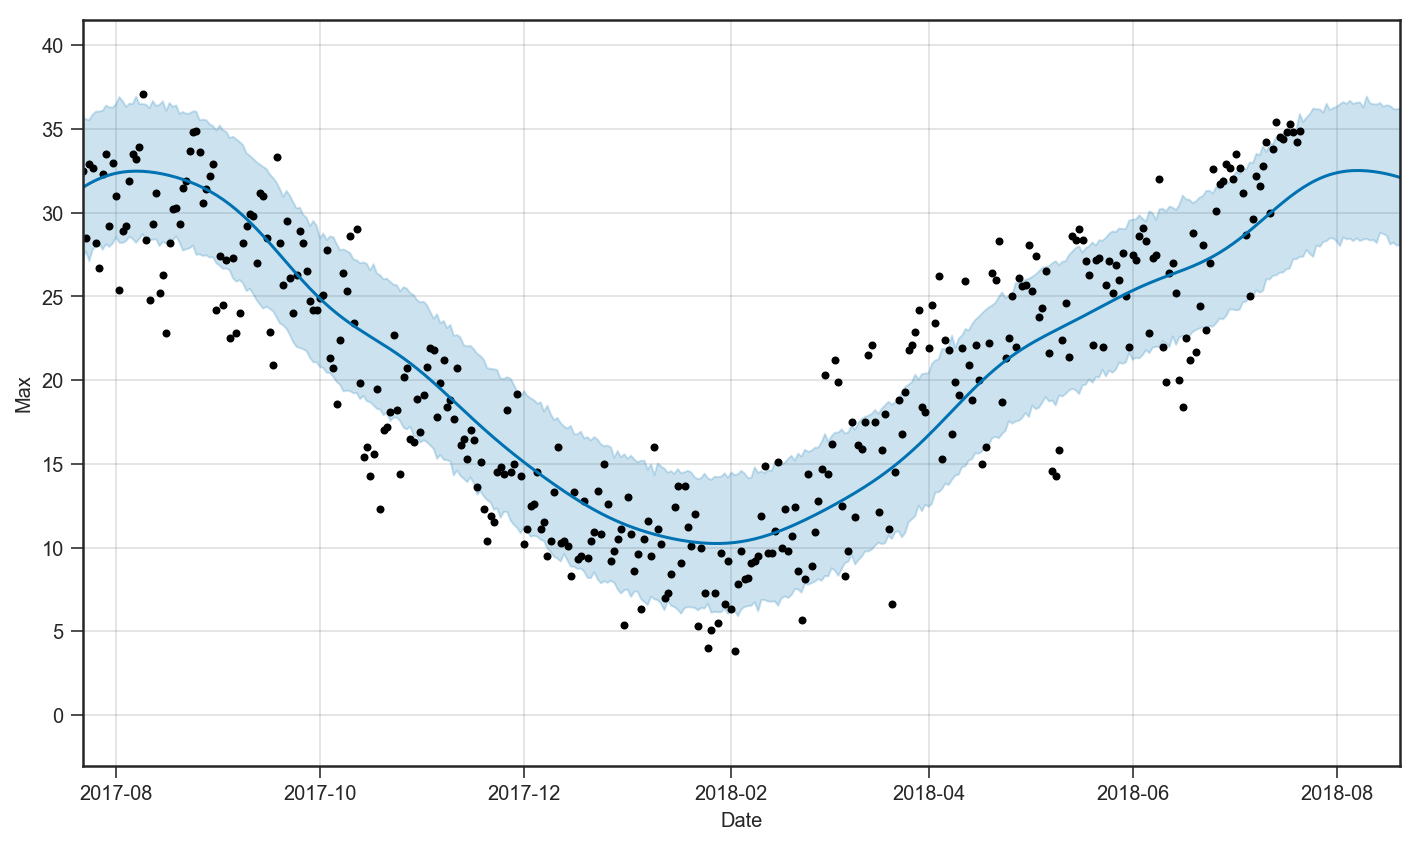

In [29]:
_ = m.plot(forecast)
plt.xlim(future.ds.iloc[-365-30], future.ds.iloc[-1])
plt.xlabel('Date')
plt.ylabel('Max')

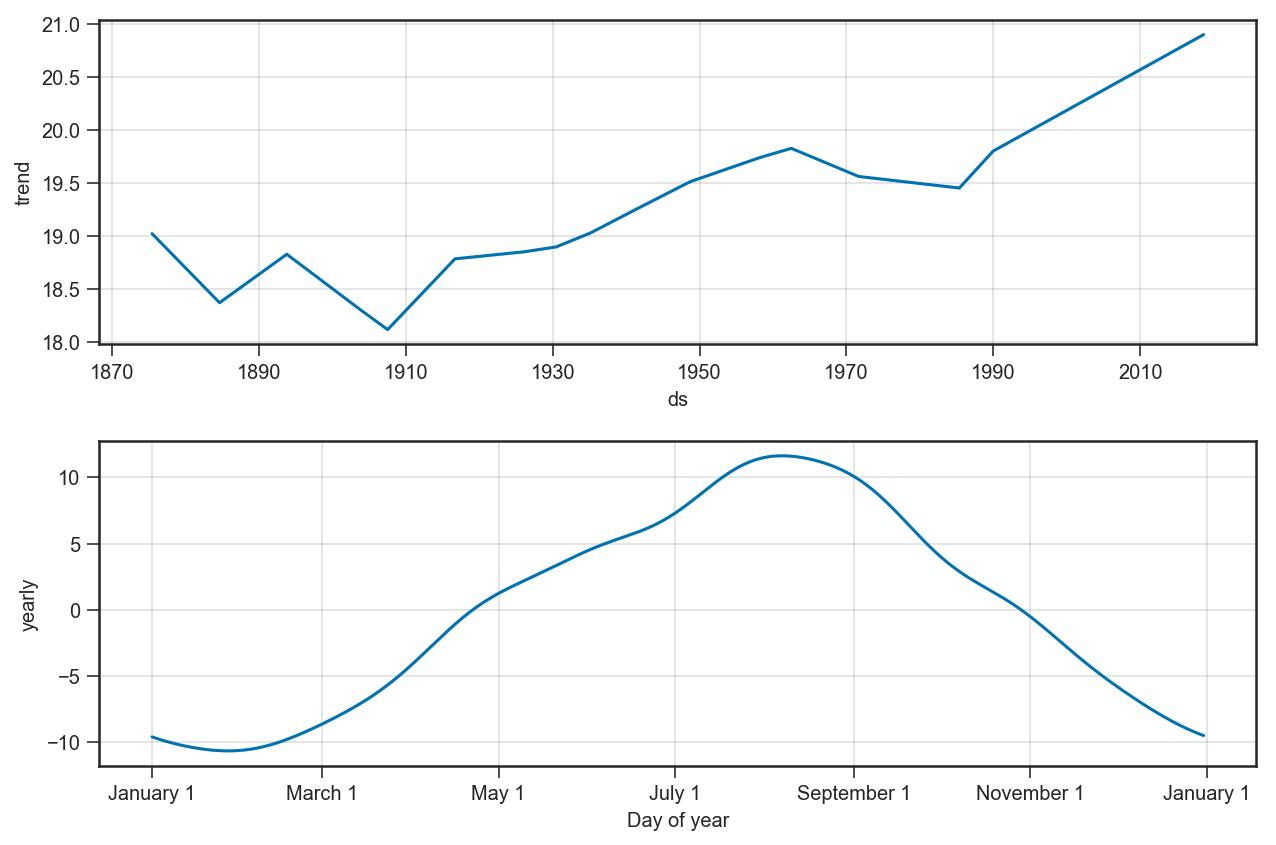

In [30]:
_ = m.plot_components(forecast)

In [31]:
forecast.iloc[-40:, [0, -1]]

,ds,yhat
52256,2018-07-12,29.953772
52257,2018-07-13,30.125824
52258,2018-07-14,30.296135
52259,2018-07-15,30.463950
52260,2018-07-16,30.628532
52261,2018-07-17,30.789168
52262,2018-07-18,30.945174
52263,2018-07-19,31.095906
52264,2018-07-20,31.240768
52265,2018-07-21,31.379213


## 最低気温

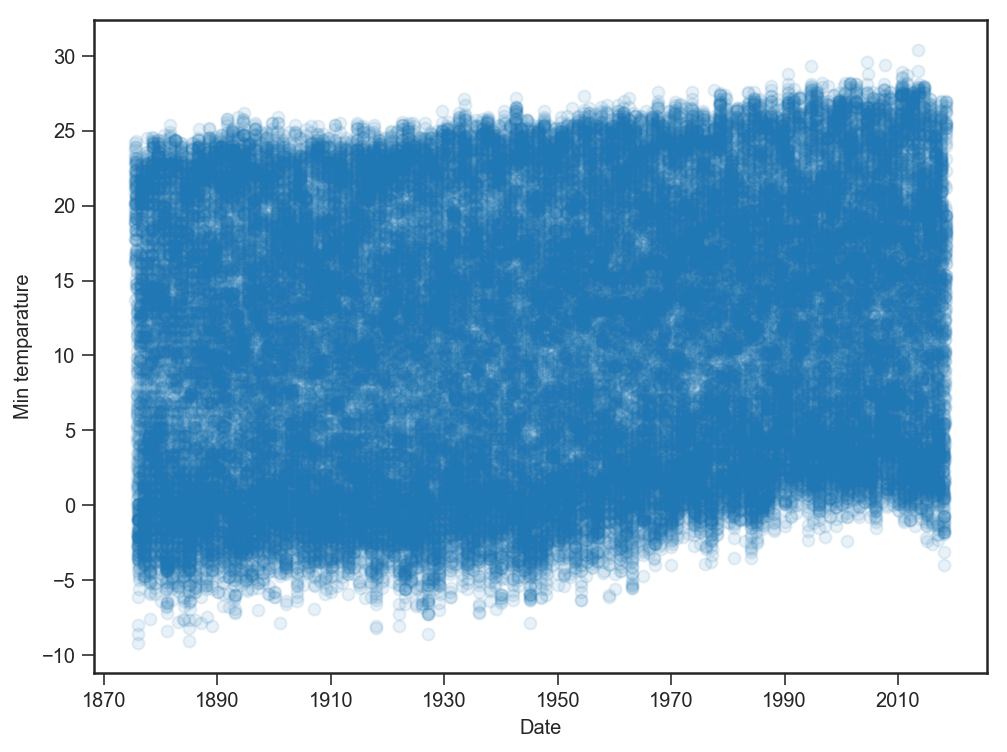

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(all_data.index, all_data.low, 'o', alpha=.1)
plt.xlabel('Date')
plt.ylabel('Min temparature')
plt.show()

In [33]:
low_data = pd.DataFrame()
low_data['ds'] = all_data.index
low_data['y'] = all_data.low.values

In [34]:
m = Prophet(weekly_seasonality=False)
m.fit(low_data)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
# 将来30日間を予測
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

Text(59.5,0.5,'Min')

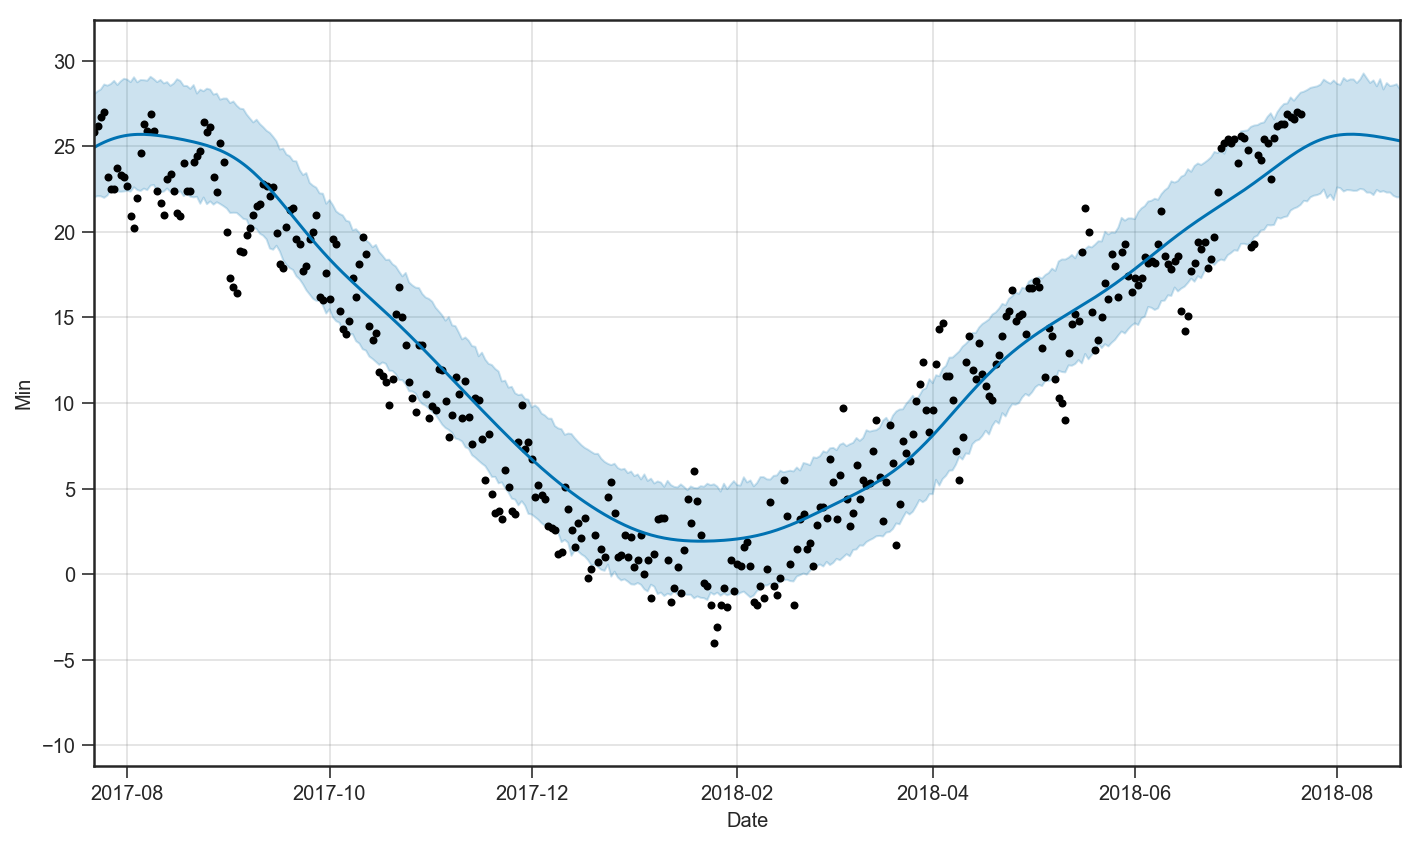

In [36]:
_ = m.plot(forecast)
plt.xlim(future.ds.iloc[-365-30], future.ds.iloc[-1])
plt.xlabel('Date')
plt.ylabel('Min')

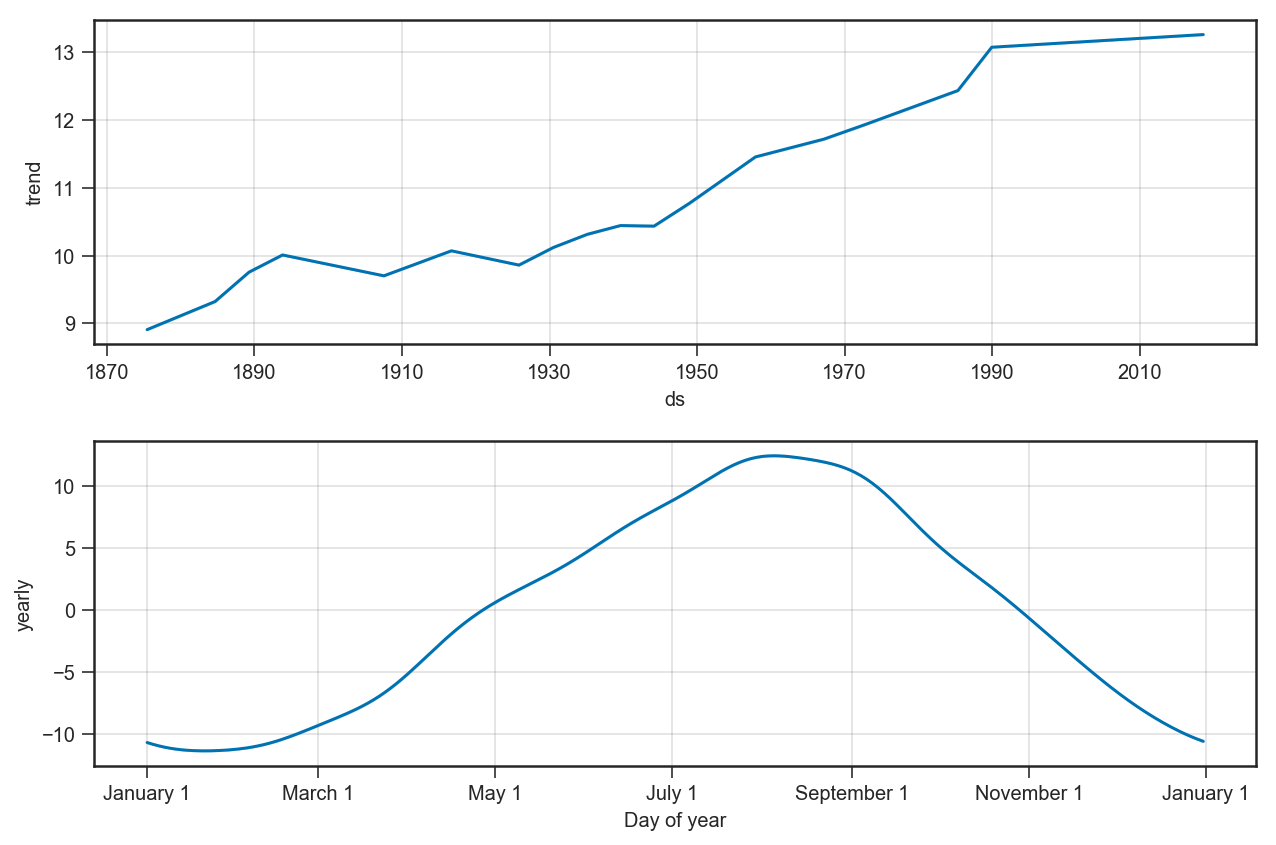

In [37]:
_ = m.plot_components(forecast)

In [38]:
forecast.iloc[-40:, [0, -1]]

,ds,yhat
52256,2018-07-12,23.569711
52257,2018-07-13,23.714654
52258,2018-07-14,23.859018
52259,2018-07-15,24.002169
52260,2018-07-16,24.143432
52261,2018-07-17,24.282102
52262,2018-07-18,24.417456
52263,2018-07-19,24.548771
52264,2018-07-20,24.675334
52265,2018-07-21,24.796459
